## Data Challenge
## Gouri Vadali

### RNA Seq QC pipeline used

1. The split replicate fastq files were first merged so that we obtain 2 replicates per state.
2. The merged fastq files underwent quality trimming, FastQC stats generation using the `trim_qc_contaminant_phix_plasmid_seq_filter.sh`. I generated a multiqc report of all the FastQC stats on every .fastq file in 1 report.
3. TruSeq adapter reads, phix reads (a regular illumina spike-in) and plasmid sequences were removed from the qc-ed fastq by using the bbduk.sh script from the bbMap tools package within the `trim_qc_contaminant_phix_plasmid_seq_filter.sh` file.
4. Once checked for all of the above, the fastq files were then aligned to the ecoli reference genome downloaded from NCBI-RefSeq using a splice aware aligner, STAR.The script used was `run_starjob.sh`
5. Once aligned to the reference genome, `htseq-counts` was used to count the genes mapped to the genome and generate a merged count matrix file (`merged_counts.txt`) to feed through the DESeq2 RNA-Seq analysis pipeline.
6. In the respoitory you will find all the scripts needed to run the QC pipeline and the files needed to run the RNA Seq DE analysis workflow to obtain the differential genes between the two states.

## Running the DESeq2 Analysis Pipeline

### Loading Libraries

In [1]:
library(DESeq2)
library(tibble)
library(reshape2)
library(RColorBrewer)
library(pheatmap)
library(dplyr)
library(ggplot2)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching package: 'S4Vectors'

The followin

### Data Wrangling

In [2]:
counts_data <- read.table("merged_counts.txt", header = FALSE, sep = '\t')
colnames(counts_data) <- c("gene","counts","sample")

### This table was generated by extracting information for genes and gene name from column 9 in the .gff3 file
ecoli_annot <- read.table("geneIDs_name.txt", header = TRUE, sep = '\t')

counts_data <- counts_data %>% filter(grepl("gene:",gene)) %>% filter(counts >= 50) %>% distinct(.keep_all = TRUE)

counts_data$gene <- gsub("gene:","",counts_data$gene)

counts_data <- tidyr::spread(counts_data,sample,counts, fill = 0)

rownames(counts_data) <- counts_data$gene

counts_data$gene <- NULL

### Plotting Count Distribution

No id variables; using all as measure variables
Warning message:
"Removed 226 rows containing non-finite values (stat_density)."

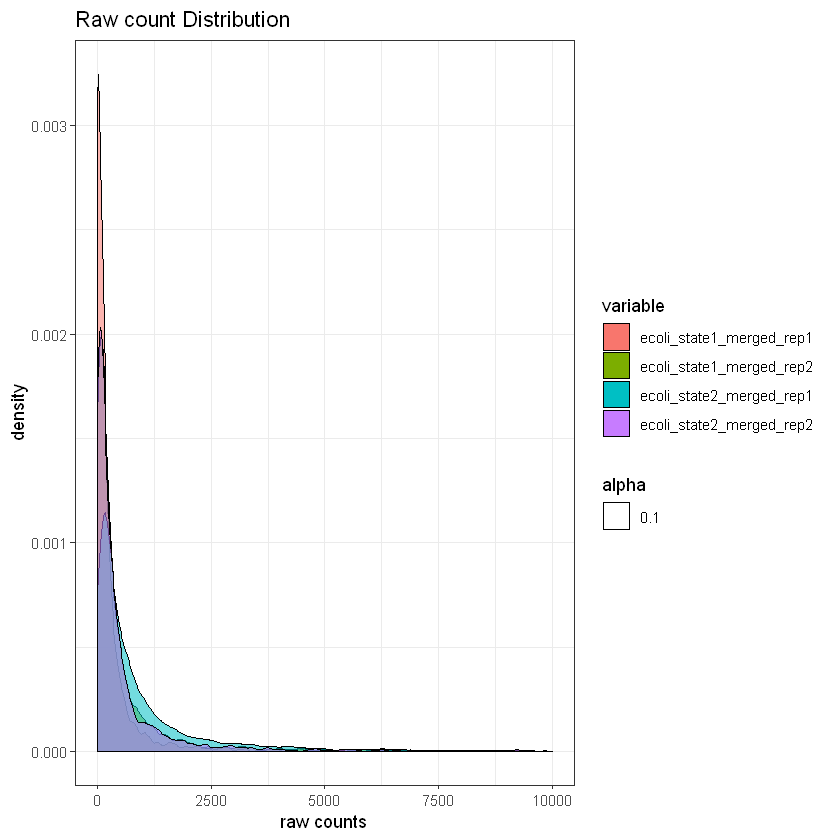

In [3]:
counts_distrib <- melt(counts_data)

ggplot(counts_distrib, aes(x = value, fill = variable))+ geom_density(aes(alpha = 0.1))+theme_bw()+xlim(0,10000)+labs(title = "Raw count Distribution",x="raw counts")

As you can see in the plot above that there are a large number of genes with low counts and many with 0 counts. We expect most genes to have a low expression and some genes to have a high expression, hence the heavily right skewed plot. I use a negative binomial distribution to model the expression of RNA-Seq data.  


### Generate Metadata

In [4]:
genotype <- c("ecoli_dh10","ecoli_dh10","ecoli_dh10","ecoli_dh10")

condition <- c("state1","state1","state2","state2")

ecoli_dh10_metadata <- data.frame(genotype, condition)

rownames(ecoli_dh10_metadata) <- c("ecoli_state1_merged_rep1","ecoli_state1_merged_rep2","ecoli_state2_merged_rep1","ecoli_state2_merged_rep2")


In [5]:
ecoli_dh10_metadata

,genotype,condition
ecoli_state1_merged_rep1,ecoli_dh10,state1
ecoli_state1_merged_rep2,ecoli_dh10,state1
ecoli_state2_merged_rep1,ecoli_dh10,state2
ecoli_state2_merged_rep2,ecoli_dh10,state2


### DE Analysis - QC - Normalization

In [6]:
# Check to see if the rownames in or metadata file is same as colnames in the raw count data
all(rownames(ecoli_dh10_metadata) == colnames(counts_data))

# Create a DESeq2 object
dds_ecoli_dh10 <- DESeqDataSetFromMatrix(countData = counts_data, colData = ecoli_dh10_metadata, design = ~ condition)

[1] TRUE

converting counts to integer mode


The design formula tells us the major source of variation to control for or regress out  as well as the condition of interest for DE testing

Raw counts should be normalized to account for differences in library depth, asses sample level quality metrics. DESeq uses "median of ratios" normalization. This method adjusts the raw counts for library size and is resistant to the large numbers of differentially expressed gene

In [7]:
# Estimate size factors used to normalize the counts per gene per sample
dds_ecoli_dh10 <- estimateSizeFactors(dds_ecoli_dh10)

# Extract the normalized counts from the DESeq2 object
norm_ecoli_dh10 <- counts(dds_ecoli_dh10, normalized = TRUE)

In [8]:
sizeFactors(dds_ecoli_dh10)

ecoli_state1_merged_rep1 ecoli_state1_merged_rep2 ecoli_state2_merged_rep1 
               0.5199821                0.9772577                2.0164430 
ecoli_state2_merged_rep2 
               0.9958248

### DE Analysis - Unsupervised Clustering Analysis

Performed to identify outliers, other major sources of variation in the data and how similar are the samples to each other with regards to gene expression

### Hierarchical Clustering & PCA

Log transformation of the normalized counts improves the visualization of the clustering. For RNA-Seq data DESeq2 uses a variant stabilizing clustering, which is a log transformation that moderates the variance across the mean

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


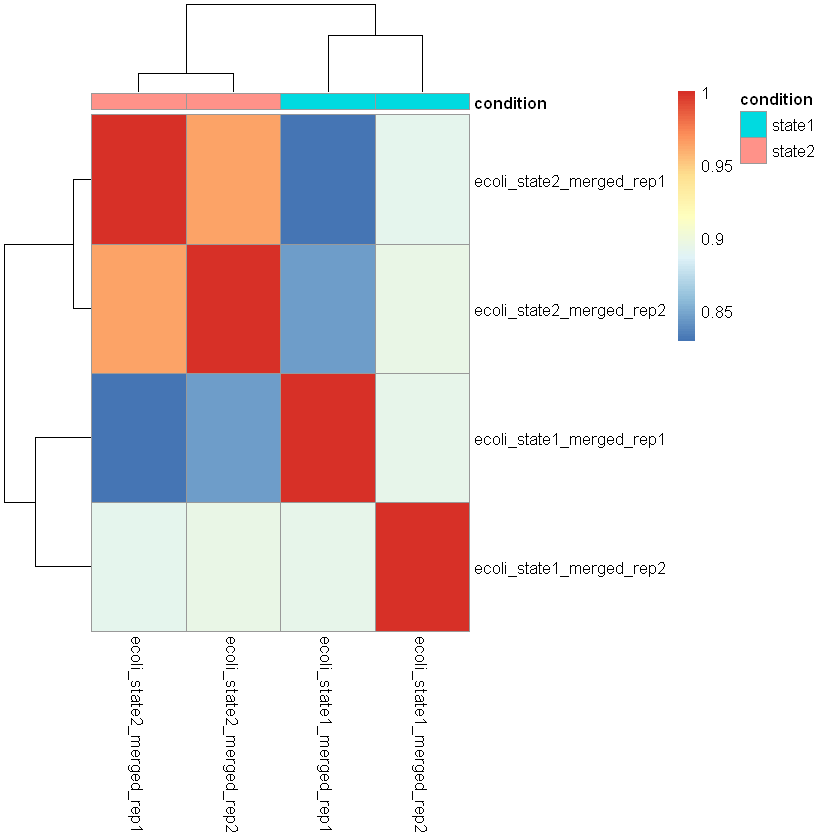

In [9]:
vsd_ecoli_dh10 <- vst(dds_ecoli_dh10, blind = TRUE)

### Generating a matrix of log2 normalized counts
vsd_mat <- assay(vsd_ecoli_dh10)

# Compute pairwise correlation values
vsd_cor <- cor(vsd_mat)

pheatmap(vsd_cor, annotation = select(ecoli_dh10_metadata, condition))

The heatmap shows that the samples within groups are clustering together and the conditions cluster separately. The DE genes between our conditions might be likely driving the separation. 

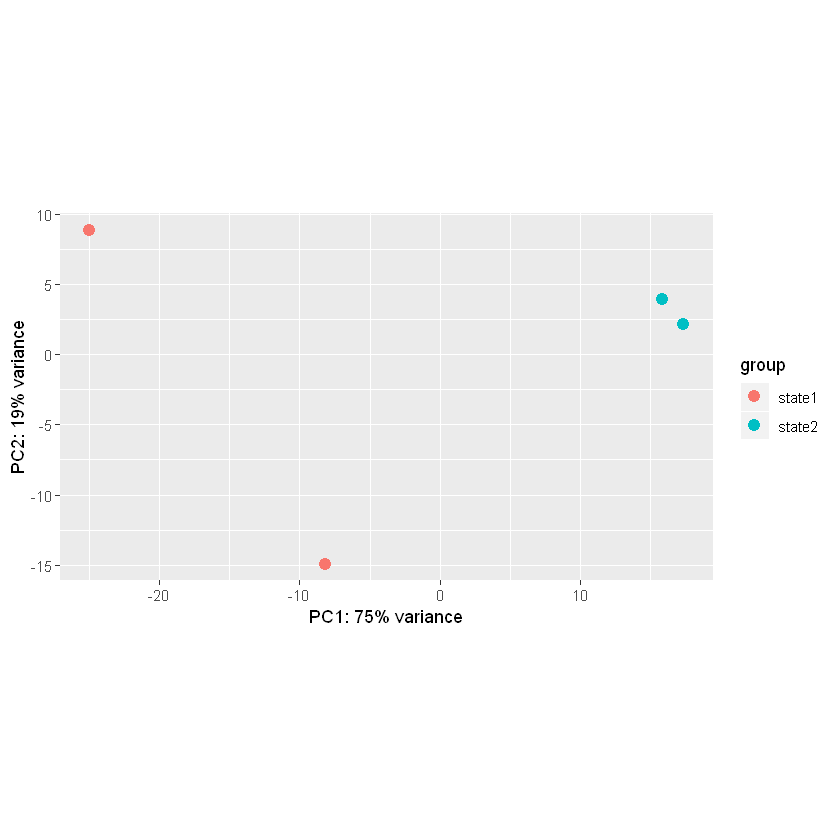

In [10]:
### PCA - finds the variation present in the dataset.
plotPCA(vsd_ecoli_dh10, intgroup = "condition")

The sample groups separate well and which is expected with RNA-Seq data. The variation is mostly explained by PC1. Interestingly, there is a large separation seen between the samples of the group state1, this might be due to the batch effects or differences in library size. 

### Modeling raw counts for each gene

Since we did not find any outliers, we proceed with running the Negative Binomial model on the DESEq2 object created earlier

In [11]:
# Run analysis
dds_ecoli_dh10 <- DESeq(dds_ecoli_dh10)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


How well did our data fit the model? The DESeq2 model uses the dispersion to assess the variability in expression when modeling the counts. This is done by plotting for dispersion estimates

We expect the dispersion values to decrease with increasing mean in RNA Seq data. The plot above shows a cloud of data (black dots), which are the genes that don't entirely cluster around the maximum likelihood line (red line). This can be due to contamination or presence of variation in samples

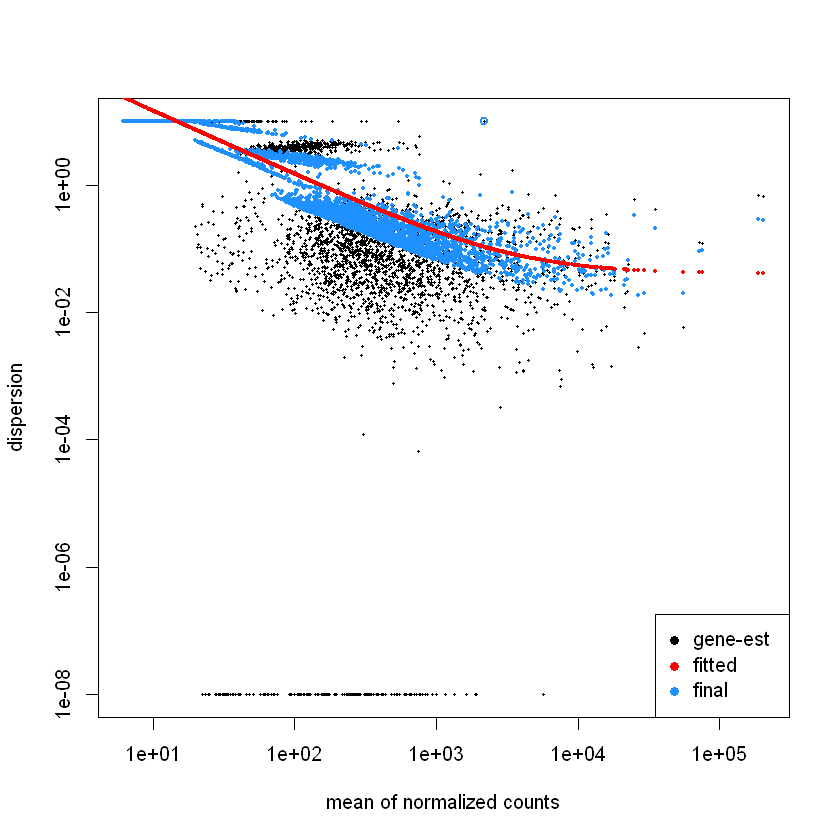

In [12]:
plotDispEsts(dds_ecoli_dh10)

To improve the estimated Fold Change(FC), we can perform log2FC shrinkage - for genes with low amounts of information associated with them.  Shrinkage uses information from all genes to generate more likely, lower log2 FC

In [13]:
# We can include a 1.25 log2FC threshold and test for significant genes. 
# Ideally, we need not apply the log2FC thresh, but when there are large # of significnat genes, 
# applying a threshold is useful.

ecoli_res <- results(dds_ecoli_dh10, contrast = c("condition","state1","state2"), alpha = 0.05, lfcThreshold = 0.32)
# Alpha denotes the significance level

ecoli_res <- lfcShrink(dds_ecoli_dh10, contrast = c("condition","state1","state2"), res = ecoli_res)

summary(ecoli_res)

using 'normal' for LFC shrinkage, the Normal prior from Love et al (2014).

Note that type='apeglm' and type='ashr' have shown to have less bias than type='normal'.
See ?lfcShrink for more details on shrinkage type, and the DESeq2 vignette.
Reference: https://doi.org/10.1093/bioinformatics/bty895



out of 3440 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 98, 2.8%
LFC < 0 (down)     : 117, 3.4%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Obtaining the gene name information for the DE results

In [14]:
#Join the annotation table with the results
ecoli_res_all <- data.frame(ecoli_res) %>% rownames_to_column(.,var = "gene")

ecoli_annot$gene <- as.character(ecoli_annot$gene)
ecoli_res_all$gene <- as.character(ecoli_res_all$gene)

ecoli_res_all <- left_join(ecoli_res_all, ecoli_annot, by = "gene")

# Subset the significant genes
sig_ecoli_dh10 <- subset(ecoli_res_all, padj < 0.05) %>% filter(!is.na(name)) %>% arrange(padj)

In [15]:
#List of Significant genes
sig_ecoli_dh10

gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,name
ECDH10B_4349,4910.1638,4.8193605,0.2678555,16.818233,1.794305e-63,6.172411e-60,frdA
ECDH10B_4523,1897.2965,-4.5317676,0.3118796,-13.501608,1.529995e-41,2.631591e-38,fhuF
ECDH10B_2363,766.1215,8.8102065,0.6410114,8.511573,1.715898e-17,1.967563e-14,napA
ECDH10B_0285,543.2880,1.0330428,0.7311618,8.330090,8.078086e-17,5.557723e-14,ykgM
ECDH10B_2312,1317.5887,-3.7295739,0.4099424,-8.352489,6.683921e-17,5.557723e-14,cirA
ECDH10B_2203,941.5378,-7.8217323,0.6821640,-7.795989,6.390618e-15,3.663955e-12,gmd
ECDH10B_1371,524.6469,7.6604750,0.6966013,7.746501,9.445937e-15,4.642004e-12,ompW
ECDH10B_0283,319.2418,0.9117007,0.7088226,7.705587,1.302434e-14,5.600466e-12,ykgL
ECDH10B_3289,297.1256,0.8951693,0.7054366,7.618524,2.565931e-14,9.807558e-12,tdcD
ECDH10B_2842,580.0996,-7.6076874,0.6710524,-7.526358,5.217534e-14,1.794832e-11,nrdE


### Visualization of the results 

#### Expression Heatmap - plotting the normalized count values instead of the sample correlation values 

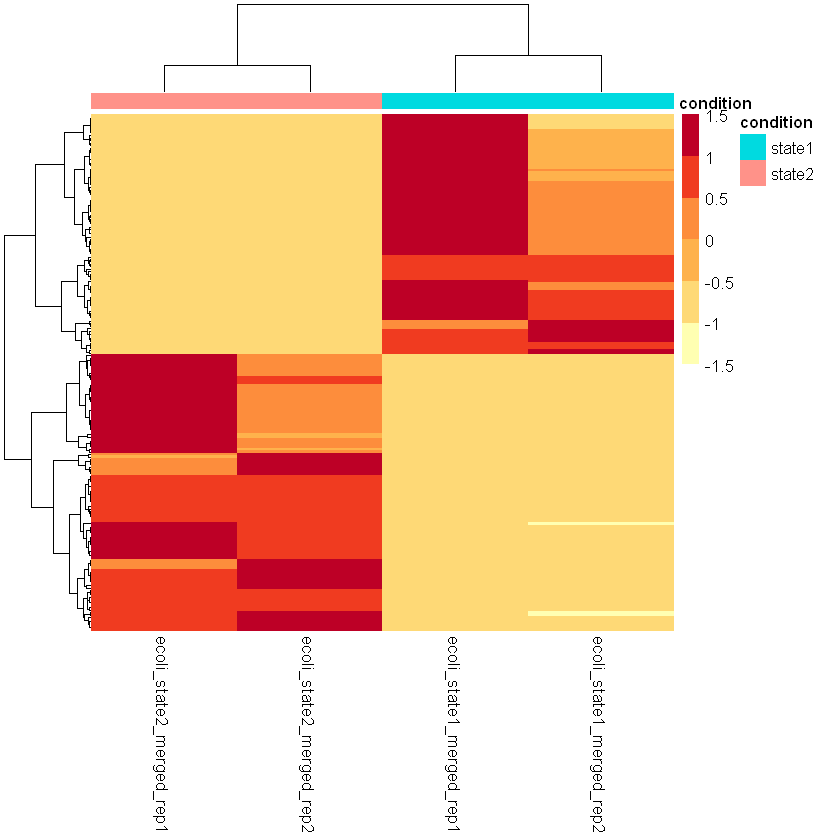

In [16]:
# Subset the normalized counts of the significnat genes
sig_norm_counts_ecoli_dh10 <- norm_ecoli_dh10[sig_ecoli_dh10$gene,]

heat_colors <- brewer.pal(6, "YlOrRd")

pheatmap(sig_norm_counts_ecoli_dh10,color = heat_colors,cluster_rows = T,show_rownames = F,annotation = select(ecoli_dh10_metadata, condition),scale = "row")

We want the expression levels for the significant genes cluster by sample group which is the case for our data

#### Volcano plot

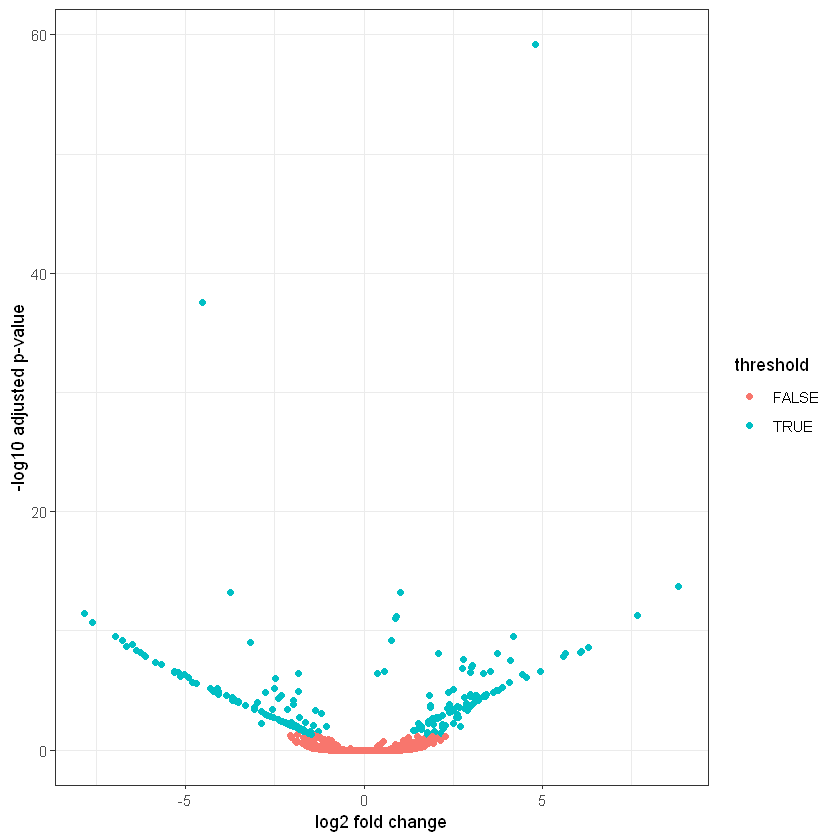

In [17]:
# Obtain logical vector regarding whether padj values are less than 0.05 
ecoli_res_all <- ecoli_res_all %>% mutate(threshold = padj < 0.05)

ggplot(ecoli_res_all) + geom_point(aes(x = log2FoldChange, y = -log10(padj),color = threshold)) + xlab("log2 fold change") + ylab("-log10 adjusted p-value") + theme(legend.position = "none",plot.title = element_text(size = rel(1.5), hjust = 0.5), axis.title = element_text(size = rel(1.25)))+theme_bw()

#### Expression plot

We will look at the top 20 genes from the differentially expressed genes

Warning message:
"Transformation introduced infinite values in continuous y-axis"

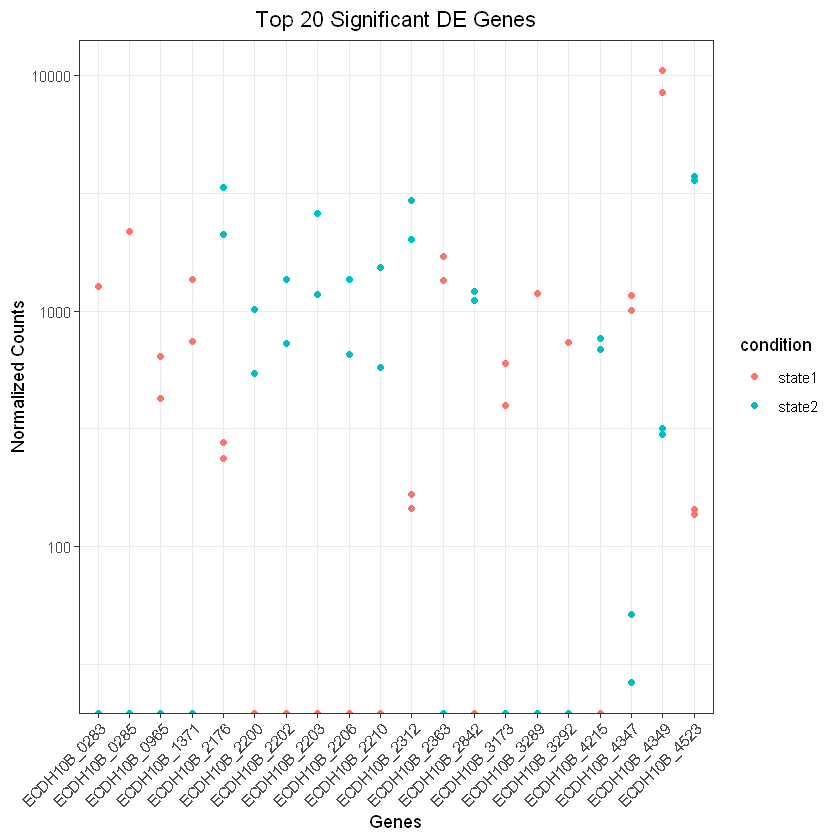

In [18]:
top_20 <- data.frame(sig_norm_counts_ecoli_dh10[1:20,]) %>% rownames_to_column(var = "gene")

top_20 <- tidyr::gather(top_20,key = "samplename",value = "normalized_counts",2:5)

# Join with the metadata
top_20 <- left_join(top_20,rownames_to_column(ecoli_dh10_metadata, var = "samplename"), by = "samplename")

ggplot(top_20) + geom_point(aes(x = gene, y = normalized_counts, color = condition)) + scale_y_log10() + xlab("Genes") + ylab("Normalized Counts") + ggtitle("Top 20 Significant DE Genes") + theme_bw() +  theme(axis.text.x = element_text(angle = 45, hjust = 1)) + theme(plot.title = element_text(hjust = 0.5))

The expression plot above shows the top 20 genes that seem to have a differential expression amoung the two states. The DE significant genes can be further used in the downstream anlaysis to perform a pathway analysis and study their mechanism in the genotype we are looking to explore.